In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import numpy as np
import fastai
from fastai.vision import *
import pandas as pd
import os
from shutil import copyfile


In [6]:
df_train = pd.read_csv('../train-rle.csv')
exp_label = 'exp2'
model_name = 'resnet34'
full_resolution = 768
half_resolution = 512
print(f"classifier_data_{full_resolution}/")

classifier_data_768/


In [7]:
np.random.seed(42)
src = (ImageList.from_folder(f"classifier_data_{full_resolution}/")
                .split_by_rand_pct(0.2)
                .label_from_folder())
# Starting with image size 256
tfms = get_transforms(do_flip=True, max_rotate=15, flip_vert=False, max_lighting=0.1,
                      max_zoom=1.05, max_warp=0.,
                      xtra_tfms=[rand_crop(), rand_zoom(1, 1.5),
                                 symmetric_warp(magnitude=(-0.2, 0.2))])
data = (src.transform(tfms, size=half_resolution)
           .databunch(bs=32, path='.').normalize(imagenet_stats))

In [8]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [9]:
precision = Precision()
recall    = Recall()
auroc     = AUROC()
learn = cnn_learner(data, models.resnet34, metrics=[accuracy,precision,recall,auroc], model_dir=".", callback_fns=ShowGraph)
learn.loss_fn = FocalLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 1.00E-02


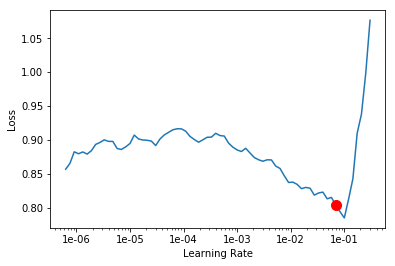

In [6]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.361919,0.355241,0.849180,0.871186,0.942543,0.881042,01:12
1,0.357225,0.335950,0.851991,0.870370,0.948044,0.894979,01:12
2,0.335120,0.324868,0.862763,0.875349,0.957213,0.906595,01:12
3,0.329528,0.316670,0.866042,0.883523,0.950489,0.910941,01:13
4,0.310192,0.301840,0.867916,0.905389,0.924205,0.916138,01:13
5,0.292843,0.300682,0.870726,0.913123,0.918704,0.917210,01:13
6,0.282511,0.298365,0.875410,0.907253,0.932763,0.919669,01:13
7,0.278480,0.296720,0.873536,0.900352,0.938875,0.921313,01:13
8,0.268137,0.293540,0.868852,0.907942,0.922372,0.921386,01:13
9,0.260330,0.293082,0.870726,0.905728,0.927873,0.921700,01:13


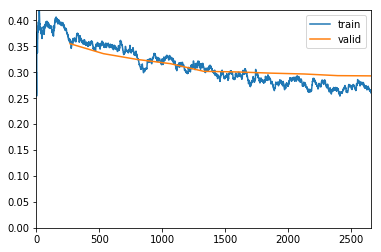

In [8]:
learn.fit_one_cycle(10,1e-3)
#learn.fit_one_cycle(1,1e-3)

In [9]:
learn.save(f"{exp_label}_pneumo_{half_resolution}_before_unfreeze")


In [11]:
learn.load(f"{exp_label}_pneumo_{half_resolution}_before_unfreeze");

In [12]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.91E-07


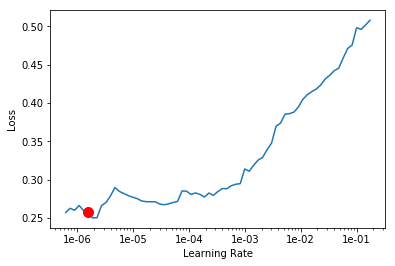

In [13]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.253806,0.366384,0.841686,0.952580,0.834963,0.920174,01:39
1,0.284656,0.304041,0.871194,0.896331,0.940709,0.917112,01:39
2,0.301394,0.356982,0.854801,0.932203,0.874083,0.906873,01:40
3,0.291061,0.296591,0.871663,0.883878,0.958435,0.924884,01:39
4,0.262360,0.270732,0.879157,0.892369,0.957824,0.937316,01:40
5,0.246058,0.272951,0.882904,0.891525,0.964548,0.937706,01:40
6,0.242167,0.276357,0.880094,0.889391,0.963325,0.941420,01:39
7,0.186860,0.269315,0.889461,0.910317,0.949266,0.940235,01:40
8,0.170702,0.268782,0.887588,0.919976,0.934597,0.938941,01:39
9,0.164111,0.270759,0.888525,0.914591,0.942543,0.940357,01:39


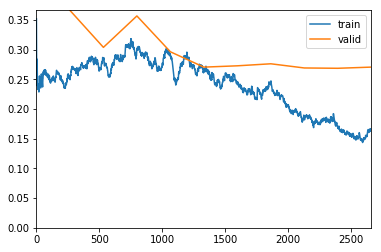

In [15]:
#learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-5))
lr = [3e-3/100, 3e-3/20, 3e-3/10]
learn.fit_one_cycle(10, lr, wd=1e-7)
#learn.fit_one_cycle(1, lr, wd=1e-7)

In [16]:
learn.save(f"{exp_label}_pneumo_{half_resolution}_after_unfreeze")

In [10]:
learn.load(f"{exp_label}_pneumo_{half_resolution}_after_unfreeze");

In [11]:
# Starting with image size 768
data = (src.transform(tfms, size=full_resolution)
           .databunch(bs=16, path='.').normalize(imagenet_stats))

In [12]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 2.29E-07


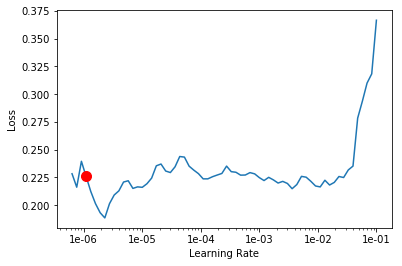

In [13]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.238535,0.300137,0.872131,0.889651,0.951100,0.925203,02:34
1,0.246868,0.299765,0.871194,0.880806,0.962103,0.934011,02:33
2,0.268261,0.270096,0.885246,0.916717,0.935208,0.934188,02:35
3,0.224891,0.331467,0.861827,0.866594,0.968826,0.927337,02:34
4,0.209978,0.323743,0.875878,0.884896,0.963325,0.932663,02:34
5,0.206594,0.329486,0.872600,0.888826,0.952934,0.927499,02:34
6,0.201651,0.336638,0.865574,0.866377,0.974939,0.936085,02:35
7,0.195078,0.304494,0.877283,0.895737,0.950489,0.937047,02:34
8,0.183405,0.327071,0.871663,0.876659,0.968826,0.935023,02:34
9,0.159167,0.331267,0.872600,0.879310,0.966381,0.935890,02:34


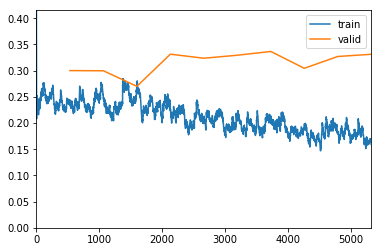

In [14]:
#learn.fit_one_cycle(4, 1e-6)
learn.fit_one_cycle(10, slice(3e-3), wd=5e-6)
#learn.fit_one_cycle(1, slice(3e-3), wd=5e-6)

In [15]:
learn.save(f"{exp_label}_pneumo_{full_resolution}_before_unfreeze")


In [16]:
learn.unfreeze()
learn = learn.clip_grad();

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.222309,0.291058,0.881030,0.895762,0.955990,0.939226,03:46
1,0.220171,0.306993,0.873536,0.929560,0.903423,0.927241,03:46
2,0.213680,0.306772,0.883841,0.901156,0.952934,0.932887,03:46
3,0.167468,0.333247,0.880094,0.887640,0.965770,0.934818,03:46
4,0.144030,0.346453,0.876815,0.883305,0.966993,0.937133,03:46


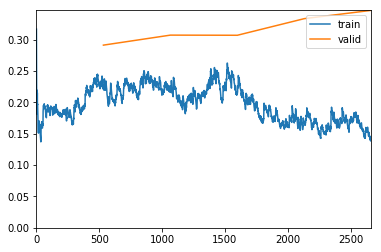

In [17]:
lr = [1e-3/200, 1e-3/20, 1e-3/10]
learn.fit_one_cycle(5, lr)
#learn.fit_one_cycle(1, lr)
#learn.fit_one_cycle(5, slice(1e-6))

In [18]:
learn.save(f"{exp_label}_pneumo_{full_resolution}_after_unfreeze")

In [30]:
# BEST MODEL is loaded before running on test data
learn.load(f"{exp_label}_pneumo_{full_resolution}_after_unfreeze")

#learn.load(f"{exp_label}_pneumo_{half_resolution}_after_unfreeze");

Learner(data=ImageDataBunch;

Train: LabelList (8540 items)
x: ImageList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: CategoryList
no_disease,no_disease,no_disease,no_disease,no_disease
Path: classifier_data_768;

Valid: LabelList (2135 items)
x: ImageList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: CategoryList
no_disease,no_disease,no_disease,no_disease,no_disease
Path: classifier_data_768;

Test: LabelList (1372 items)
x: ImageList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: EmptyLabelList
,,,,
Path: classifier_data_768, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dila

In [31]:
sample_df = pd.read_csv('../sample_submission.csv')
sample_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6067.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6214.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6177.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6655.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6359.151787519...,-1


In [32]:
learn.data.add_test(ImageList.from_df(sample_df,f'../data{full_resolution}/',folder='test',suffix='.png'))

In [33]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)
cls_pred = F.softmax(preds,1).argmax(1).cpu().numpy()

In [34]:
paths = list(map(str,list(learn.data.test_ds.x.items)))
all_test_paths = [p.split('/')[-1][:-4] for p in paths]

df_preds = pd.DataFrame()
df_preds['test_paths'] = all_test_paths
df_preds['class_pred'] = cls_pred

df_preds.set_index('test_paths',inplace=True)

In [35]:
df_preds.head()

,class_pred
test_paths,
1.2.276.0.7230010.3.1.4.8323329.6067.1517875195.915618,1
1.2.276.0.7230010.3.1.4.8323329.6214.1517875197.83920,1
1.2.276.0.7230010.3.1.4.8323329.6177.1517875196.880733,0
1.2.276.0.7230010.3.1.4.8323329.6655.1517875199.413686,1
1.2.276.0.7230010.3.1.4.8323329.6359.1517875197.803699,1


In [36]:
no_dis_idx = df_preds[df_preds.class_pred==1].index
print(len(no_dis_idx))

1184


In [38]:
sub = pd.read_csv('new_aug.csv',index_col=['ImageId'])
sub.head(25)
sub.fillna(value=' -1',inplace=True)
sub.head()


,EncodedPixels
ImageId,
1.2.276.0.7230010.3.1.4.8323329.6067.1517875195.915618,-1
1.2.276.0.7230010.3.1.4.8323329.6214.1517875197.83920,-1
1.2.276.0.7230010.3.1.4.8323329.6177.1517875196.880733,562270 4 1019 6 1006 23 997 30 991 34 989 35 9...
1.2.276.0.7230010.3.1.4.8323329.6655.1517875199.413686,-1
1.2.276.0.7230010.3.1.4.8323329.6359.1517875197.803699,-1


In [39]:
sub.loc[no_dis_idx] = ' -1'


In [40]:
sub.to_csv(f'{exp_label}_{model_name}_{half_resolution}_{full_resolution}_classifier_correction_trained_on_768.csv')